# Predicting Sleep Disorder Using Health and Lifestyle Data

**Course:** STAT 301  
**Date:** April 12, 2025   
**Group Members:** Linda Chu, Mohammed Fouzan Hashmi, Tarun Narayan

## Introduction

### Background Information

Sleep is integral to every individual's quality of life. Unfortunately, many people suffer from various sleep disorders that disrupt both their sleep quality and consistency. For example, obstructive sleep apnea is a common yet frequently underdiagnosed sleep-related respiratory disorder characterized by repeated occurrences where the upper airway is blocked while sleeping, preventing airflow (Gooneratne & Vitiello, 2014). In contrast, insomnia is a sleep-related psychological disorder defined as the persistent difficulty of initiating sleep, staying asleep, or waking up early (Chaiard & Weaver, 2019). Overall, sleep largely influences and is influenced by various factors including daily lifestyle and health. As such, it is important to be able to detect the presence of sleep disorders in order to ensure proper diagnosis and treatment.

This study will explore the prediction of whether individuals have sleep disorders based on lifestyle and health data from the **Sleep Health and Lifestyle Dataset**.

### Question of Interest
Can we predict whether an individual has a sleep disorder based on the available relevant categories in the dataset?

## Methods and Results

### a.) Data
The Sleep Health and Lifestyle Dataset contains 400 observations and 13 variables, providing insights into sleep patterns, lifestyle factors, and cardiovascular health. The dataset includes numerical and categorical variables.

**Source:** The data source is artificial (i.e., the author of the dataset created synthetic data for illustrative purposes).  
**Citation:** Dataset retrieved from: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data.

Variables in the dataset:

| Variable                  | Type        | Description                                   |
|---------------------------|------------|-----------------------------------------------|
| **Person ID**             | Categorical | Unique identifier for each individual         |
| **Gender**                | Categorical | Male/Female                                  |
| **Age**                   | Numerical   | Age in years                                 |
| **Occupation**            | Categorical | Type of profession                          |
| **Sleep Duration**        | Numerical   | Hours of sleep per day                      |
| **Quality of Sleep**      | Numerical   | Self-reported sleep quality (1-10)          |
| **Physical Activity Level** | Numerical | Minutes of physical activity per day       |
| **Stress Level**          | Numerical   | Self-reported stress level (1-10)           |
| **BMI Category**          | Categorical | Underweight, Normal, Overweight             |
| **Blood Pressure**        | Numerical   | Systolic/Diastolic measurement              |
| **Heart Rate**            | Numerical   | Beats per minute (bpm)                      |
| **Daily Steps**           | Numerical   | Number of steps per day                     |
| **Sleep Disorder**        | Categorical | None, Insomnia, Sleep Apnea                 |

*Credit for the data description above goes to Mohammed Fouzan Hashmi.*

**Column that will be removed:** Person ID.   
**Reason:** This is a unique identifier for each individual and does not provide any meaningful information for prediction or analysis.


### b) Exploratory Data Analysis

In [1]:
library(tidyverse)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(gridExtra)
library(broom)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘caret’ was built under R version 4.3.3”
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Warning message:
“package ‘pROC’ was built under R version 4.3.3”
Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Warning message:
“package ‘boot’ was built under R version 4.3.3

In [7]:
# Load the dataset
sleep_data <- read_csv("https://raw.githubusercontent.com/Tarun-Narayan/STAT301-GroupProject/refs/heads/main/sleep_health.csv", show_col_types = FALSE)

# Clean and wrangle data into a tidy format
sleep_data <- sleep_data %>%
  drop_na() %>%
  distinct()

# Rename column names to remove space
sleep_data <- sleep_data %>%
  rename(ID = `Person ID`,
         Sleep_Duration = `Sleep Duration`, 
         Sleep_Quality = `Quality of Sleep`,
         Phys_Level = `Physical Activity Level`,
         Stress_Level = `Stress Level`, 
         Sleep_Disorder = `Sleep Disorder`,
         BMI_Category = `BMI Category`,
         Blood_Pressure = `Blood Pressure`,
         Heart_Rate = `Heart Rate`,
         Daily_Steps = `Daily Steps`)

# Combine 'Normal Weight' and 'Normal' into one category
sleep_data <- sleep_data %>%
  mutate(BMI_Category = ifelse(BMI_Category == "Normal Weight", "Normal", BMI_Category))

# Split Blood pressure into Systolic BP and Diastolic BP
sleep_data <- sleep_data %>%
  separate(Blood_Pressure, into = c("Systolic_BP", "Diastolic_BP"), sep = "/", convert = TRUE) 

# Modify Sleep_Disorder and BMI_Category to factor
sleep_data <- sleep_data %>% 
  mutate(Sleep_Disorder = ifelse(Sleep_Disorder == "None", 0, 1), 
         Sleep_Disorder = as.factor(Sleep_Disorder),
         BMI_Category = as.factor(BMI_Category))

glimpse(sleep_data)

Rows: 374
Columns: 14
$ ID             <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ Gender         <chr> "Male", "Male", "Male", "Male", "Male", "Male", "Male",…
$ Age            <dbl> 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29,…
$ Occupation     <chr> "Software Engineer", "Doctor", "Doctor", "Sales Represe…
$ Sleep_Duration <dbl> 6.1, 6.2, 6.2, 5.9, 5.9, 5.9, 6.3, 7.8, 7.8, 7.8, 6.1, …
$ Sleep_Quality  <dbl> 6, 6, 6, 4, 4, 4, 6, 7, 7, 7, 6, 7, 6, 6, 6, 6, 5, 6, 5…
$ Phys_Level     <dbl> 42, 60, 60, 30, 30, 30, 40, 75, 75, 75, 30, 75, 30, 30,…
$ Stress_Level   <dbl> 6, 8, 8, 8, 8, 8, 7, 6, 6, 6, 8, 6, 8, 8, 8, 8, 7, 8, 7…
$ BMI_Category   <fct> Overweight, Normal, Normal, Obese, Obese, Obese, Obese,…
$ Systolic_BP    <int> 126, 125, 125, 140, 140, 140, 140, 120, 120, 120, 120, …
$ Diastolic_BP   <int> 83, 80, 80, 90, 90, 90, 90, 80, 80, 80, 80, 80, 80, 80,…
$ Heart_Rate     <dbl> 77, 75, 75, 85, 85, 85, 82, 70, 70, 70, 70, 70, 70, 70,…
$ Daily_Steps    <

In [8]:
# Summary tables to view counts per category
count(sleep_data, Occupation)

# There is only 1 Manager. As such, only one of the training or testing sets will have this category.
# Therefore we will combine it with 'Sales Represenative' and 'Salesperson' into 'Business'.

sleep_data <- sleep_data %>% 
  mutate(Occupation = ifelse(Occupation == "Manager", "Business", Occupation)) %>%
  mutate(Occupation = ifelse(Occupation == "Sales Representative", "Business", Occupation)) %>%
  mutate(Occupation = ifelse(Occupation == "Salesperson", "Business", Occupation))

count(sleep_data, Sleep_Disorder)

# The two groups (with sleep disorder and without sleep disorder) are relatively balanced.

count(sleep_data, BMI_Category)

# The BMI_Category groups are unbalanced; few are in the 'Obese' category. This category was omitted from the Kaggle description.
# We will leave it untouched. 

Occupation,n
<chr>,<int>
Accountant,37
Doctor,71
Engineer,63
Lawyer,47
Manager,1
Nurse,73
Sales Representative,2
Salesperson,32
Scientist,4


Sleep_Disorder,n
<fct>,<int>
0,219
1,155


BMI_Category,n
<fct>,<int>
Normal,216
Obese,10
Overweight,148


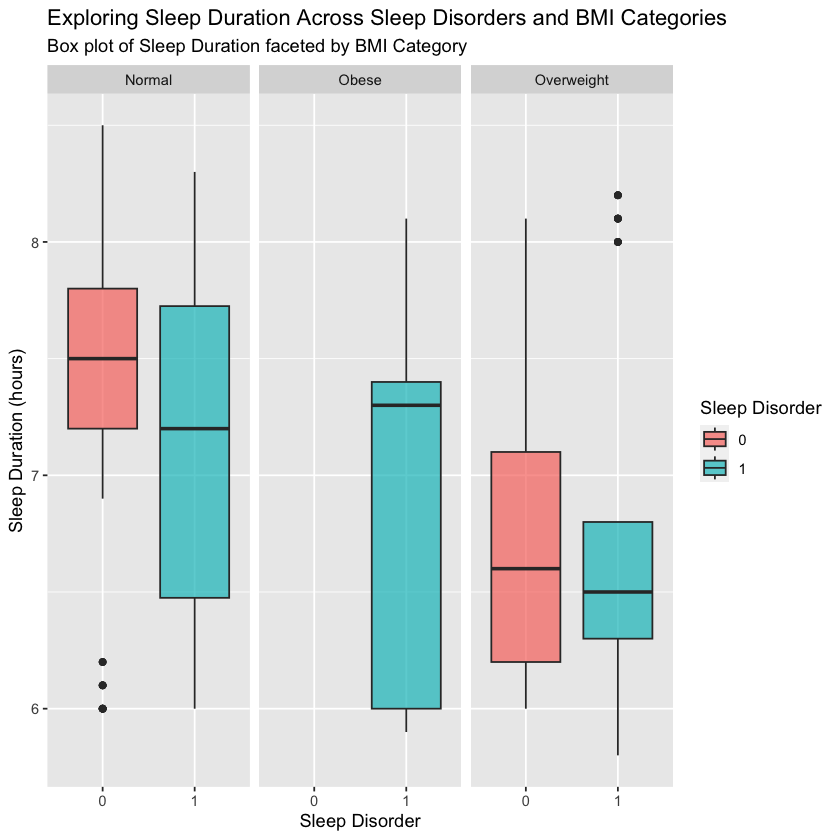

In [9]:
# Visualization 1: 
# Exploring the associations of Sleep Duration with Sleep Disorder and BMI Categories

# BoxPlot: Sleep Duration vs Sleep Disorder, faceted by BMI Category
ggplot(sleep_data, aes(x = Sleep_Disorder, y = Sleep_Duration, fill = Sleep_Disorder)) +
  geom_boxplot(alpha = 0.7) +
  facet_wrap(~ BMI_Category) + 
  labs(
    title = "Exploring Sleep Duration Across Sleep Disorders and BMI Categories",
    subtitle = "Box plot of Sleep Duration faceted by BMI Category",
    x = "Sleep Disorder",
    y = "Sleep Duration (hours)",
    fill = "Sleep Disorder"
  ) 

# Credit for the boxplot goes to Tarun Narayan.

`geom_smooth()` using formula = 'y ~ x'


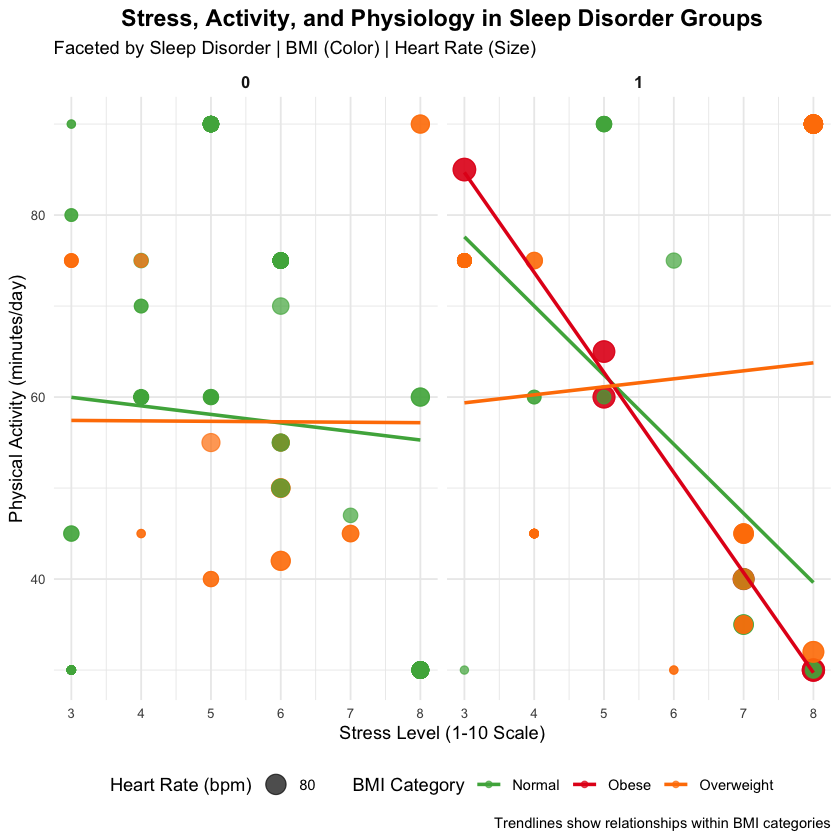

In [10]:
# Visualization 2: 
# Stress, Activity, and Physiology in Sleep Disorder Groups

# Custom theme for readability
theme_custom <- theme_minimal() +
 theme(
 plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
 strip.text = element_text(face = "bold", size = 10),
 legend.position = "bottom",
 axis.text = element_text(size = 8)
 )

# Credit for the theme_custom goes to Mohammed Fouzan Hashmi

# ScatterPlot: 
sleep_data |>
  ggplot(aes(x = Stress_Level, y = Phys_Level)) +
  geom_point(
    aes(color = BMI_Category, size = Heart_Rate),
    alpha = 0.7
  ) +
  # Facet by Sleep Disorder
  facet_wrap(~ Sleep_Disorder, nrow = 1) +
  # Color palette for BMI categories
  scale_color_manual(
    name = "BMI Category",
    values = c("Normal" = "#4daf4a", "Overweight" = "#ff7f00", "Obese" = "#e41a1c")
  ) +
  scale_size_continuous(
    name = "Heart Rate (bpm)",
    range = c(2, 6),
    breaks = c(60, 80, 100)
  ) +   
# trendlines for each BMI category
  geom_smooth(
    aes(group = BMI_Category, color = BMI_Category),
    method = "lm", se = FALSE
  ) +
  labs(
    title = "Stress, Activity, and Physiology in Sleep Disorder Groups",
    subtitle = "Faceted by Sleep Disorder | BMI (Color) | Heart Rate (Size)",
    x = "Stress Level (1-10 Scale)",
    y = "Physical Activity (minutes/day)",
    caption = "Trendlines show relationships within BMI categories"
  ) +
  theme_custom

### Why the boxplot is relevant:

> 1. Detecting Patterns in Sleep Disorders:
The plot helps us compare how sleep duration varies for different sleep disorders. For example, from the plot, we observe that individuals with Insomnia tend to have shorter sleep durations across BMI categories, and this effect appears more pronounced in the obese category.

> 2. Identifying the Role of BMI in Sleep Disorders:
Faceting by BMI Category helps us explore whether overweight or obese individuals are more prone to sleep disorders. This is important in identifying whether high/low BMI is a risk factor for sleep disorders. For example, from the plot, we observe that overweight and obese individuals on average sleep less than individuals with normal weight.

### Why the scatterplot is relevant:

> The scatterplot provided us with some valuable insights:
> 1. Obese individuals with sleep disorders experience the strongest negative relationship between stress and physical activity.
> 2. In contrast, for those without sleep disorders, the relationship between stress and activity is more stable or only mildly negative across BMI categories.
> 3. Heart rate tends to be higher (indicated by the larger dots) in those with sleep disorders, particularly obese individuals.

### Potential problems/ Limitations:
> Small Sample Size per Group:
The number of observations for each BMI category and sleep disorder group may be limited (especially noticeable in the "Obese" group, which has only 10 data points), potentially affecting the reliability of trendlines. 

### c) Methods: Plan

We will split the data into a training set (70%) and a test set (30%). On the training set, we will use Lasso for variable selection and fit a logistic regression model using the selected variables. Finally, we will evaluate our model's ability to predict whether an individual has a sleep disorder or not on the testing set (Yes/No = 1/0).

This method is appropriate because: The response variable (Sleep_Disorder, which is a categorical variable with 3 categories) can be transformed into a binomial variable (i.e., has Sleep disorder/ doesn't have sleep disoder).
Logistic regression models the probability of an outcome using a logistic function.
It allows us to analyze how the response variables influence the likelihood of having a sleep disorder.
Additionally, using Lasso for variable selection is appropriate as the dataset has a large number of variables and it will allow us to simplify our model and reduce overfitting.

### Assumptions:
1) Binary Response: The response variable must have only two categories (Yes/No).
2) Independence: Observations must be independent of one another.
3) Variance Structure: The variance follows a binomial distribution, highest when 
p=0.5.
4) Linearity in Log-Odds: The log of the odds should have a linear relationship with the predictors.

### Potential Limitations: 
1) Linearity Assumption: If the relationship between predictors and log-odds is non-linear, transformations may be needed.
2) Class Imbalance: Unequal distribution of 1/0 cases may affect predictive performance.
3) Unobserved Variables: Other important factors (e.g., genetics, caffeine intake) which may be indicators for sleep disorders are not included in this model.

In [11]:
set.seed(123) 

# Split dataset into training (70%) and testing (30%) sets
sleep_train <- sleep_data %>% slice_sample(prop = 0.7)
sleep_test <- sleep_data %>% anti_join(sleep_train, by = "ID")

# Remove ID column for both
sleep_train <- sleep_train %>% select(-`ID`)
sleep_test <- sleep_test %>% select(-`ID`)

head(sleep_train)
nrow(sleep_train)

Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Phys_Level,Stress_Level,BMI_Category,Systolic_BP,Diastolic_BP,Heart_Rate,Daily_Steps,Sleep_Disorder
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<dbl>,<dbl>,<fct>
Male,42,Lawyer,7.8,8,90,5,Normal,130,85,70,8000,0
Male,29,Doctor,6.0,6,30,8,Normal,120,80,70,8000,0
Male,43,Business,6.5,6,45,7,Overweight,130,85,72,6000,1
Female,51,Nurse,6.1,6,90,8,Overweight,140,95,75,10000,1
Female,37,Accountant,7.2,8,60,4,Normal,115,75,68,7000,0
Female,51,Engineer,8.5,9,30,3,Normal,125,80,65,5000,0


[1] 261

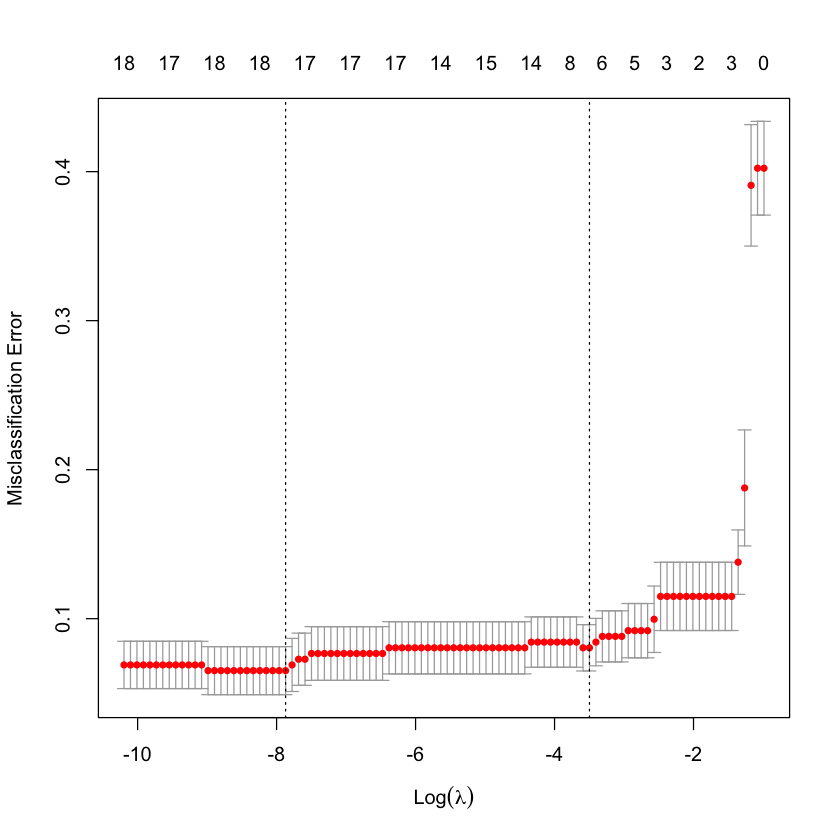

In [12]:
set.seed(123)

# Create the matrix of predictors for our lasso model
sleep_X <- model.matrix(object = Sleep_Disorder ~ ., data = sleep_train)[, -1] 

# Extract our response variable column
sleep_Y <- sleep_train$Sleep_Disorder

# Fit a Lasso regression model with cross-validation
sleep_lasso <- cv.glmnet(sleep_X, sleep_Y,        # our predictors and response
                         family = "binomial",     # use logistic regression as our response is binary
                         type.measure = "class")  # use classification accuracy for cross-validation
plot(sleep_lasso)

In [13]:
# View selected covariates from lasso
selected_vars <- coef(sleep_lasso, s = "lambda.min")

selected_vars

21 x 1 sparse Matrix of class "dgCMatrix"
                                       s1
(Intercept)                 -6.819017e+01
GenderMale                   3.277827e-01
Age                          1.947871e-01
OccupationBusiness           .           
OccupationDoctor            -1.187777e+01
OccupationEngineer          -6.693648e+00
OccupationLawyer            -6.911987e+00
OccupationNurse             -3.147023e+00
OccupationScientist         -3.211041e+00
OccupationSoftware Engineer -6.059923e+00
OccupationTeacher            7.527128e-01
Sleep_Duration              -5.188547e-03
Sleep_Quality               -5.883401e-01
Phys_Level                  -1.196816e-02
Stress_Level                 4.313780e-01
BMI_CategoryObese            .           
BMI_CategoryOverweight      -7.940590e+00
Systolic_BP                  .           
Diastolic_BP                 6.524346e-01
Heart_Rate                   2.867288e-01
Daily_Steps                 -9.294192e-04

In [14]:
# Prediction

# Subset the testing dataset, only include (non zero-ed) selected covariates
test_X <- model.matrix(Sleep_Disorder ~ ., data = sleep_test)[, -1]

# Make the predictions with the test set
sleep_test$Predicted_Prob <- predict(sleep_lasso, newx = test_X, type = "response")
sleep_test$Predicted_Disorder <- ifelse(sleep_test$Predicted_Prob > 0.5, "1", "0")

# Create confusion matrix
conf_matrix <- confusionMatrix(
   data = as.factor(sleep_test$Predicted_Disorder),
   reference = as.factor(sleep_test$Sleep_Disorder),
   positive = "1"
)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 60  8
         1  3 42
                                          
               Accuracy : 0.9027          
                 95% CI : (0.8325, 0.9504)
    No Information Rate : 0.5575          
    P-Value [Acc > NIR] : 1.121e-15       
                                          
                  Kappa : 0.8006          
                                          
 Mcnemar's Test P-Value : 0.2278          
                                          
            Sensitivity : 0.8400          
            Specificity : 0.9524          
         Pos Pred Value : 0.9333          
         Neg Pred Value : 0.8824          
             Prevalence : 0.4425          
         Detection Rate : 0.3717          
   Detection Prevalence : 0.3982          
      Balanced Accuracy : 0.8962          
                                          
       'Positive' Class : 1               
                                    

Setting levels: control = 0, case = 1

Warning message in roc.default(response = as.numeric(sleep_test$Sleep_Disorder) - :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



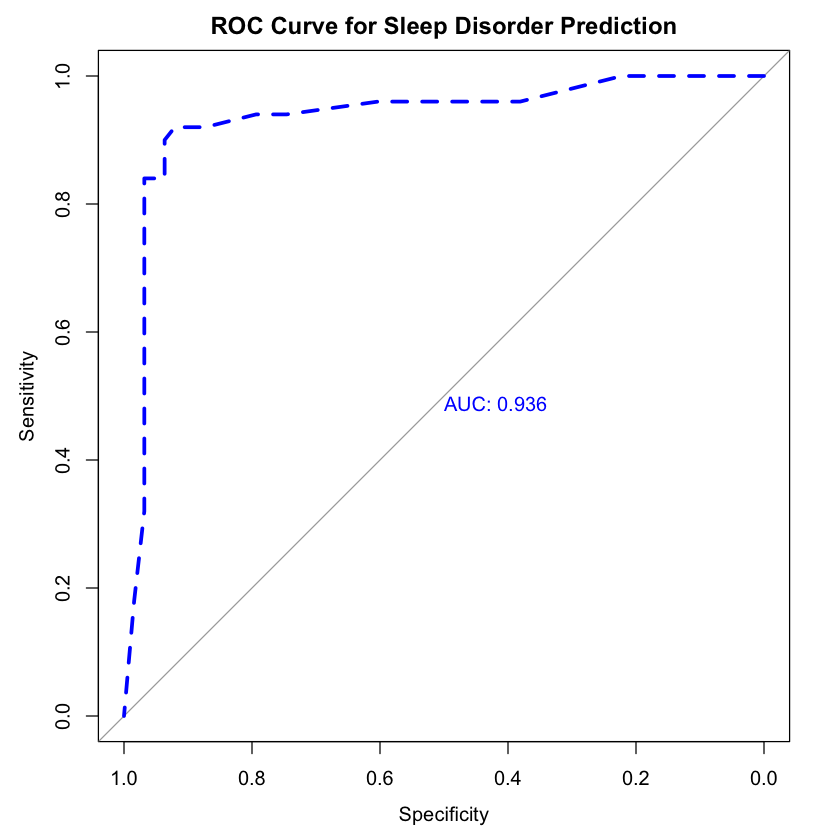

In [15]:
# ROC Curve
ROC_logit <- roc(
  response = as.numeric(sleep_test$Sleep_Disorder) - 1,  
  predictor = sleep_test$Predicted_Prob
)

# Plot ROC Curve
plot(ROC_logit,
     print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "ROC Curve for Sleep Disorder Prediction")

## Discussion

The ROC curve shows that the logistic regression model performs well in predicting sleep disorders, with an AUC of 0.936, indicating strong discriminatory power. The model effectively distinguishes between individuals with and without sleep disorders, as seen from the steep rise in sensitivity. This confirms that these factors (i.e., Age, BMI, Sleep duration, Blood Pressure, etc.) play a significant role in sleep disorder classification. Further refinement, such as incorporating additional predictors or handling potential class imbalances, could enhance model performance. These findings align with existing literature that highlights the impact of sleep duration on sleep quality and disorders (Gooneratne, N. S., & Vitiello, M. V. (2014)).

The confusion matrix further supports the model’s effectiveness, showing high accuracy (90.27%) and strong specificity (95.24%). The model successfully identifies the majority of individuals without sleep disorders, but it also performs well at detecting those with sleep disorders, as indicated by the sensitivity of 84.00%.

#### Areas for improvement: 
1. Class imbalance is one concern, with fewer individuals diagnosed with sleep disorders compared to those without. Although this did not drastically impact the model, future work could include techniques like oversampling or SMOTE to address this imbalance and improve prediction for the underrepresented class.
2. Since the data is synthetic, the data does not reflect real world variability or underlying population distributions, it may not generalize beyond the scope of this project. This can be improved by collecting observations from real life instead.
4. Another improvement could involve exploring more complex models beyond logistic regression, such as random forests or support vector machines, which may better capture non-linear relationships and interactions between variables.
   
#### Future questions/research
1. One interesting question is investigating the temporal relationship of how changes in lifestyle factors (e.g., physical activity and stress level) over time influence the development or worsening of sleep disorders.
2. Expanding the study to incorporate genetic information or sleep tracking data (e.g., from fittness bands) could offer deeper insights into the predictors of sleep disorders and further refine predictive models. 
3. Exploring the psychological factors that contribute to sleep disorders—such as mental health conditions or work-related stress—could provide a more comprehensive understanding of the root causes and help devise better solutions.

## References

Chaiard, J., & Weaver, T. E. (2019). Update on research and practices in major sleep disorders: Part II—Insomnia, Willis‐Ekbom disease (restless leg syndrome), and narcolepsy. Journal of Nursing Scholarship, 51(6), 624-633. https://doi.org/10.1111/jnu.12515

Gooneratne, N. S., & Vitiello, M. V. (2014). Sleep in older adults. Clinics in Geriatric Medicine, 30(3), 591-627. https://doi.org/10.1016/j.cger.2014.04.007